In [1]:
!pip install pyspark
!pip install pyhive
!pip install thrift
!pip install thrift-sasl
!pip install scikit-learn
!pip install matplotlib


In [2]:
from pyhive import hive
import matplotlib.pyplot as plt
import pandas as pd

# Connect to Hive
conn = hive.connect(host='34.118.243.34', port=10000, username='hive', database='github')

# Execute a Hive query
query = 'SELECT * FROM github_repos'
hive_df = pd.read_sql(query, conn)


<ipython-input-2-3a5f0cdb0ae6>:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hive_df = pd.read_sql(query, conn)


In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("GitHubTrends").getOrCreate()

df = spark.createDataFrame(hive_df)

# Print the first 10 rows of the DataFrame
df.show(10)

+--------------------+------------------+------------------+---------------------+-------------------------+----------------------------+-------------------------------------+----------------------+--------------------+
|   github_repos.name|github_repos.stars|github_repos.forks|github_repos.watchers|github_repos.pullrequests|github_repos.primarylanguage|github_repos.defaultbranchcommitcount|github_repos.createdat|github_repos.licence|
+--------------------+------------------+------------------+---------------------+-------------------------+----------------------------+-------------------------------------+----------------------+--------------------+
|        freeCodeCamp|            371122|             33158|                 8446|                    33649|                  TypeScript|                              33585.0|  2014-12-24T17:49:19Z|BSD 3-Clause "New...|
|         public-apis|            252370|             28947|                 3897|                     3016|            

[('github_repos.name', 'string'), ('github_repos.stars', 'bigint'), ('github_repos.forks', 'bigint'), ('github_repos.watchers', 'bigint'), ('github_repos.pullrequests', 'bigint'), ('github_repos.primarylanguage', 'string'), ('github_repos.defaultbranchcommitcount', 'string'), ('github_repos.createdat', 'string'), ('github_repos.licence', 'string')]


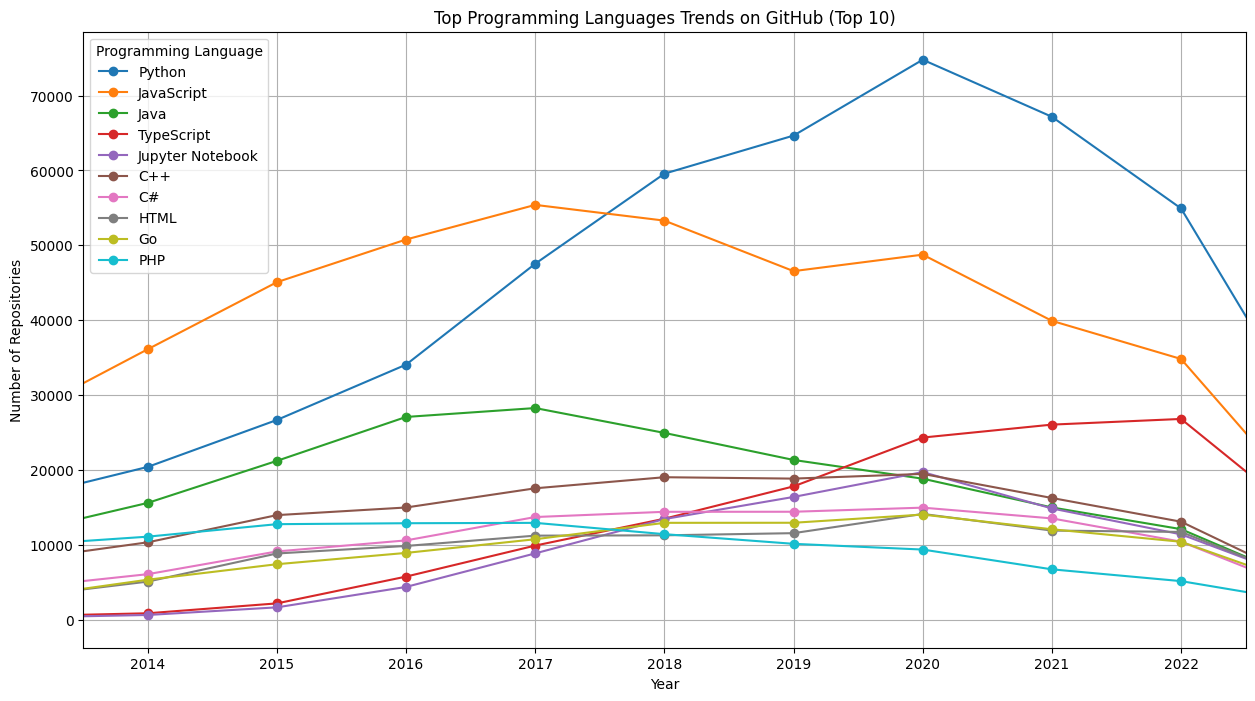

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, explode
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, regexp_extract
from pyspark.sql.functions import split
from pyspark.sql.functions import to_timestamp

print(df.dtypes)

df = df.withColumn("`github_repos.createdat`", to_timestamp(df["`github_repos.createdat`"], "yyyy-MM-dd'T'HH:mm:ss'Z'"))

# Extract year from the timestamp column
df = df.withColumn("year", year(df["`github_repos.createdat`"]))

# Explode the primary_language column
df = df.withColumn("primaryLanguage", explode(split(col("`github_repos.primarylanguage`"), ", ")))

# Group by year and language to get counts
language_counts = df.groupBy("year", "primaryLanguage").count().orderBy("year")

# Convert Spark DataFrame to Pandas DataFrame for visualization
pd_df = language_counts.toPandas()

# Pivot the data for better visualization
pivot_df = pd_df.pivot(index='year', columns='primaryLanguage', values='count').fillna(0)

# Plotting
plt.figure(figsize=(15, 8))

# Displaying only a subset of languages
languages_to_display = pivot_df.max().nlargest(10).index.tolist()

# Plotting for selected languages with line graph
for column in languages_to_display:
    plt.plot(pivot_df.index, pivot_df[column], label=column, marker='o', linestyle='-')

plt.title('Top Programming Languages Trends on GitHub (Top 10)')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.legend(title='Programming Language')

# Adjust x-axis limits to ensure full visibility of data for 2014 and 2022
plt.xlim(2013.5, 2022.5)
plt.grid(True)

plt.show()

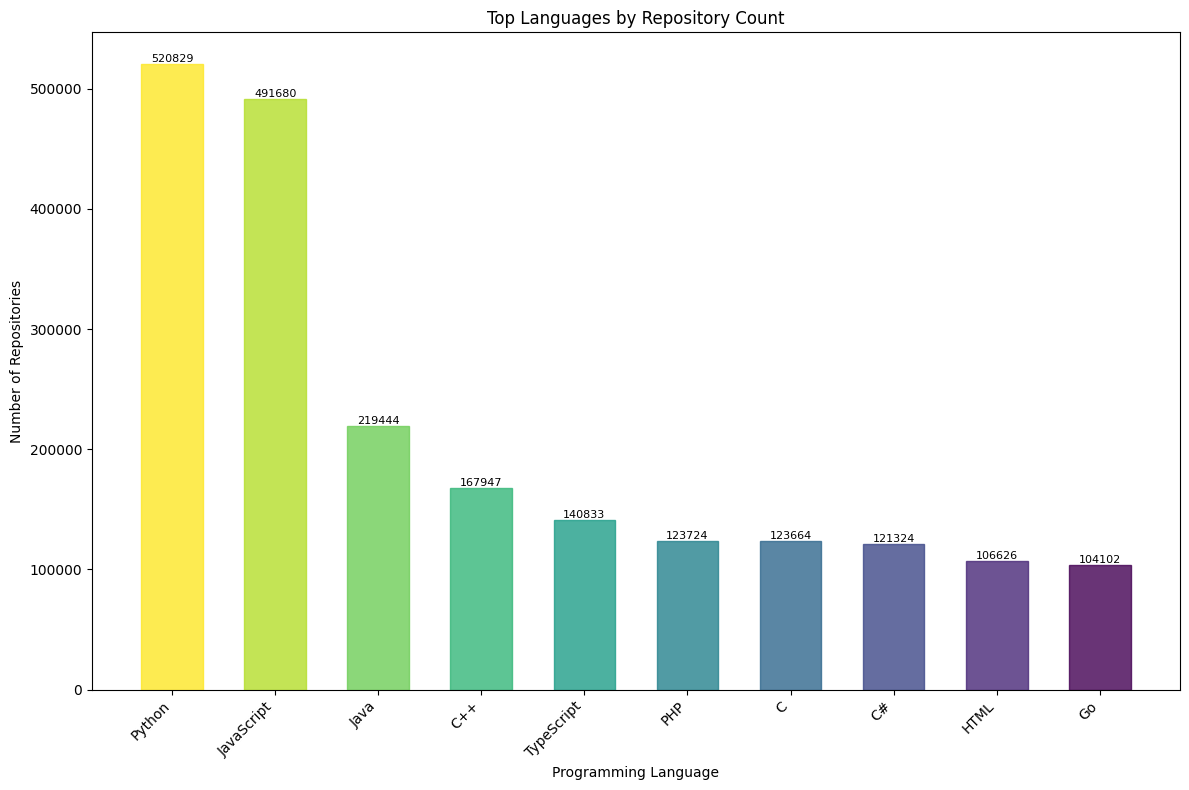

In [5]:
# Top languages used based on repo and primary languages
from pyspark.sql.functions import explode, col
import numpy as np

# Explode the list of languages
df = df.withColumn("language", explode(split(col("`github_repos.primarylanguage`"), ", ")))

# Calculate total repositories for each language
language_counts = df.filter(col("language").isNotNull()) \
    .groupBy("language").count().orderBy("count", ascending=False)

# Convert Spark DataFrame to Pandas DataFrame
language_counts_pd = language_counts.toPandas()

# Take the top languages
top_languages = language_counts_pd.head(10)  # Adjust the number of languages to display

# Create a color gradient for bars
colors = plt.cm.viridis_r(np.linspace(0, 1, len(top_languages)))

# Plotting with gradient colors for bars
plt.figure(figsize=(12, 8))  # Adjusted figure size
bars = plt.bar(top_languages["language"], top_languages["count"], alpha=0.8, width=0.6)

# Apply gradient colors to bars and annotate each bar with its count
for idx, (bar, color) in enumerate(zip(bars, colors)):
    bar.set_color(color)
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 5, top_languages["count"].iloc[idx],
             ha='center', va='bottom', fontsize=8, color='black')  # Adjusted annotation parameters

plt.title('Top Languages by Repository Count')
plt.xlabel('Programming Language')
plt.ylabel('Number of Repositories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

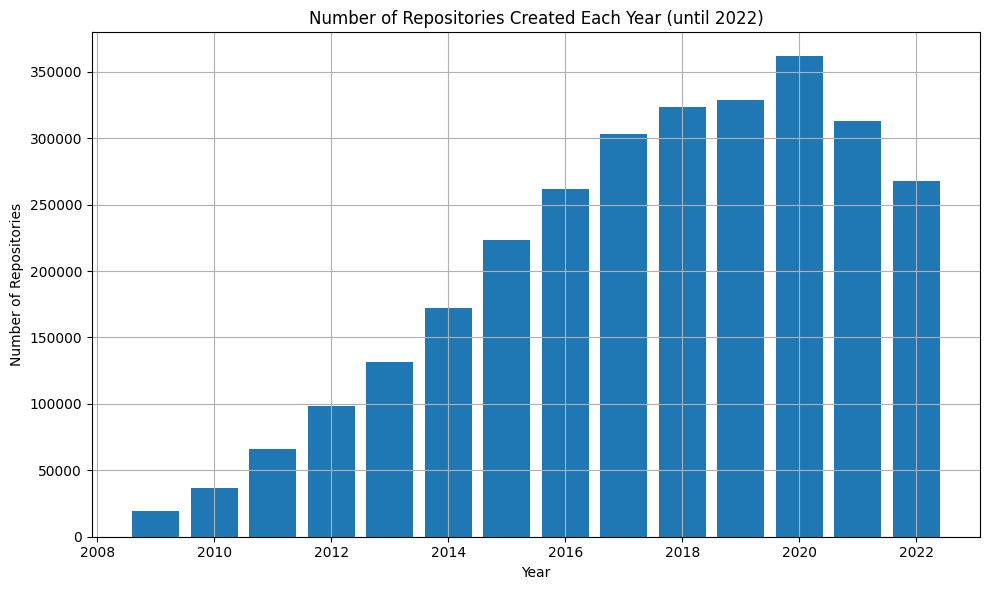

In [6]:
from pyspark.sql.functions import year
import matplotlib.pyplot as plt

# Assuming 'created_at' is a timestamp column in your DataFrame
df = df.withColumn('year', year('`github_repos.createdat`'))

# Filter the DataFrame for years until 2022
df_filtered = df.filter(df['year'] <= 2022)

# Group by year and count the repositories
repositories_per_year = df_filtered.groupBy('year').count().orderBy('year')

# Convert Spark DataFrame to Pandas DataFrame for plotting
repositories_per_year_pd = repositories_per_year.toPandas()

# Plotting the repository count based on year until 2022
plt.figure(figsize=(10, 6))
plt.bar(repositories_per_year_pd['year'], repositories_per_year_pd['count'])
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.title('Number of Repositories Created Each Year (until 2022)')
plt.grid(True)
plt.tight_layout()
plt.show()

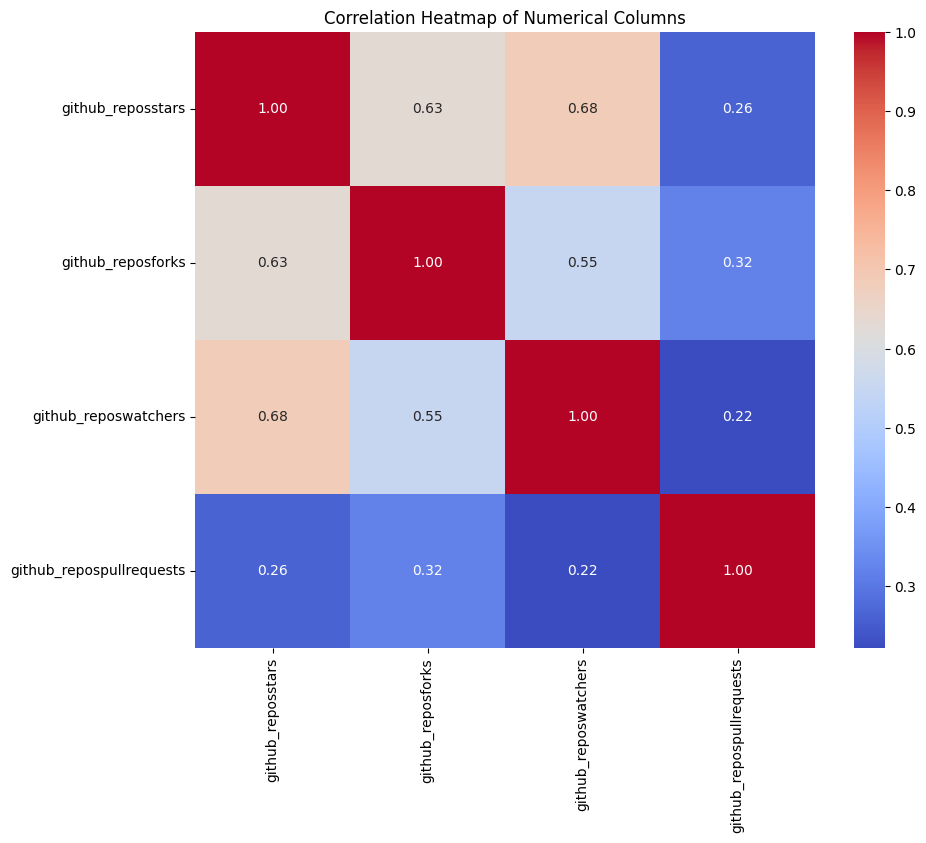

In [7]:
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Assuming 'df' is your DataFrame
new_column_names = [col.replace('.', '') for col in df.columns]

# Rename columns without dots
for old_col, new_col in zip(df.columns, new_column_names):
    df = df.withColumnRenamed(old_col, new_col)

# Assuming 'df' is your DataFrame containing numerical columns
# Selecting numerical columns
numerical_cols = [col_name for col_name, data_type in df.dtypes if data_type == 'bigint' or data_type == 'double']

# Vectorize the numerical columns
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")

assembled_df = assembler.transform(df).select("features")

# Calculate correlation matrix
correlation_matrix = Correlation.corr(assembled_df, "features").head()
corr_array = correlation_matrix[0].toArray()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_array, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=numerical_cols, yticklabels=numerical_cols)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()


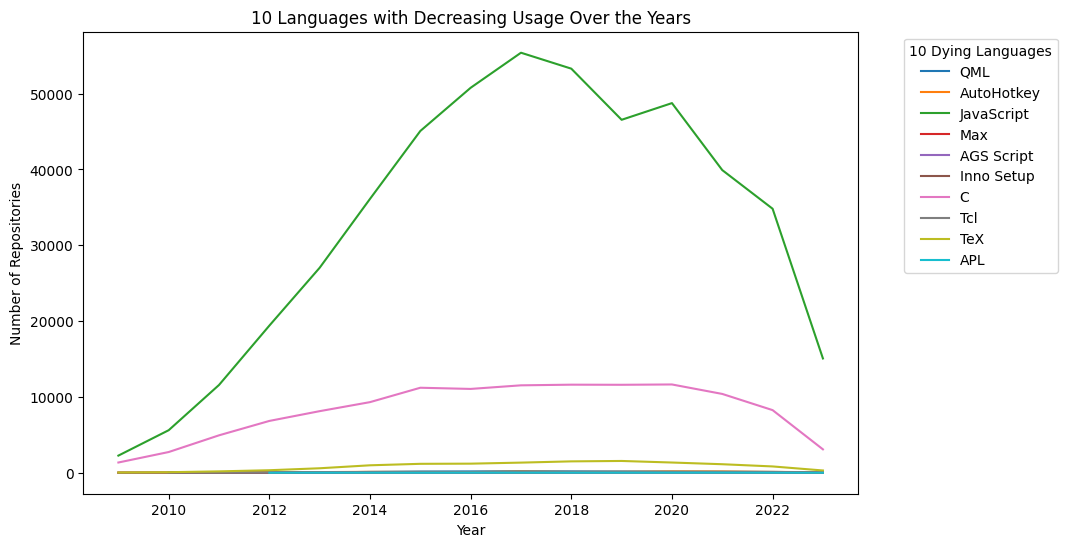

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, explode, col, split
import matplotlib.pyplot as plt

# Extract year from the timestamp column
df = df.withColumn("year", year(df["`github_reposcreatedat`"]))

# Explode the primary_language column
df = df.withColumn("primaryLanguage", explode(split(col("`github_reposprimarylanguage`"), ", ")))

# Group by year and language to get counts
language_counts = df.groupBy("year", "primaryLanguage").count().orderBy("year", "primaryLanguage")

# Convert Spark DataFrame to Pandas DataFrame for further analysis
pd_df = language_counts.toPandas()

# Pivot the data to prepare for comparison between years
pivot_df = pd_df.pivot(index='primaryLanguage', columns='year', values='count').fillna(0)

# Calculate the percentage change in count for each language over the years
pivot_df['change'] = (pivot_df[2022] - pivot_df[2014]) / pivot_df[2014] * 100

# Get the least 10 languages that are decreasing in usage over the years
dying_languages = pivot_df[pivot_df['change'] < 0].nlargest(10, 'change').index.tolist()

# Filter DataFrame to include only the least 10 dying languages
dying_df = pd_df[pd_df['primaryLanguage'].isin(dying_languages)]

# Set up distinct colors for each language
colors = plt.cm.tab10.colors[:len(dying_languages)]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plotting the least 10 languages with decreasing usage over the years using distinct colors
for idx, language in enumerate(dying_languages):
    data = dying_df[dying_df['primaryLanguage'] == language]
    plt.plot(data['year'], data['count'], label=language, color=colors[idx])

# Show the legend on the right side
plt.legend(title='10 Dying Languages', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.title('10 Languages with Decreasing Usage Over the Years')

# Show the plot
plt.show()